## Time series foreacasting
### Back to the Machine Learning Workflow

Time series forecasting is a `regression` problem! We want to predict a set of scalars from features that we have.

---

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1. Define the business Goal


- `Temperature project`: 
    - Make a short term (what's the temperature for tomorrow/next week) time series forecast 
    - Other ideas:
        - Make several forecasts to decide where to spend the next camping trip next weekend
        - Make forecast to check probability of a flight being canceled because of weather conditions
        - Measure impact of temperature change over time in different countries/different cities
        - ... other goals ... homework for the team members ;) 

## 2. Get the Data

### 2.1 Load the Data

In [4]:
mystation = 'Frankfurt_Stadt'

In [5]:
df = pd.read_csv('../data/ECA_blended_Frankfurt_Stadt/data.csv')

In [6]:
df.shape

(55303, 4)

In [7]:
df.head()

,SOUID,DATE,TG,Q_TG
0,122376,18700101,-24,0
1,122376,18700102,26,0
2,122376,18700103,25,0
3,122376,18700104,26,0
4,122376,18700105,12,0


EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 09-08-2021
THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:

Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE IS -9999):
- 01-06 SOUID: Source identifier
- 08-15 DATE : Date YYYYMMDD
- 17-21 TG   : mean temperature in 0.1 &#176;C
- 23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, FRANKFURT/MAIN (STADT) (STAID: 4105).
Blended and updated with sources: 121248 122352 122364 122376 127008 910637 
See file sources.txt and stations.txt for more info.


### 2.2 Clean the Data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55303 entries, 0 to 55302
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0    SOUID    55303 non-null  int64
 1       DATE  55303 non-null  int64
 2      TG     55303 non-null  int64
 3    Q_TG     55303 non-null  int64
dtypes: int64(4)
memory usage: 1.7 MB


In [9]:
df.columns

Index([' SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object')

In [10]:
df.columns = [name.strip() for name in df.columns]
df.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG'], dtype='object')

In [11]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df.head()

,SOUID,DATE,TG,Q_TG
0,122376,1870-01-01,-24,0
1,122376,1870-01-02,26,0
2,122376,1870-01-03,25,0
3,122376,1870-01-04,26,0
4,122376,1870-01-05,12,0


In [12]:
df['INDEX'] = df.index
df.head()

,SOUID,DATE,TG,Q_TG,INDEX
0,122376,1870-01-01,-24,0,0
1,122376,1870-01-02,26,0,1
2,122376,1870-01-03,25,0,2
3,122376,1870-01-04,26,0,3
4,122376,1870-01-05,12,0,4


In [13]:
df.SOUID.value_counts()

122376    33571
122364    12904
122352     8310
127008      426
910637       61
121248       31
Name: SOUID, dtype: int64

In [14]:
df.Q_TG.value_counts()

0    55210
9       93
Name: Q_TG, dtype: int64

----

`_Hint for the Temperature Data_`: 
- Pay attention to reading the data in the right format with the right units 
    - Check units! Temperature can be measured in different ones! 
- Check the unexpected values in an overview to see what might need to be corrected.

**Unexpected values?**
- Not numbers
- Too extreme values, e.g. +100 C degrees is not a correct value

---

## 3. Train-Test-Split
Define `X` and `y`?

- Our `X` is the time (+ the passengers _in the past_ (`ENCOUNTER: linear autoregression`))
- Our `y` is the passengers 

-> Model dependance between datapoints in the data set

- Our `train` is the passengers _in the past_ 
- Our `test` is the passengers _in the future_

In [16]:
# define index for date, where test data starts
split_index = df.loc[df.DATE == '2011-01-01'].index[0]
split_index

51499

In [17]:
df_train = df[:split_index].copy()

In [18]:
df_test = df[split_index:].copy()

In [19]:
df_train.shape, df_test.shape

((51499, 5), (3804, 5))

## 4. Data Exploration

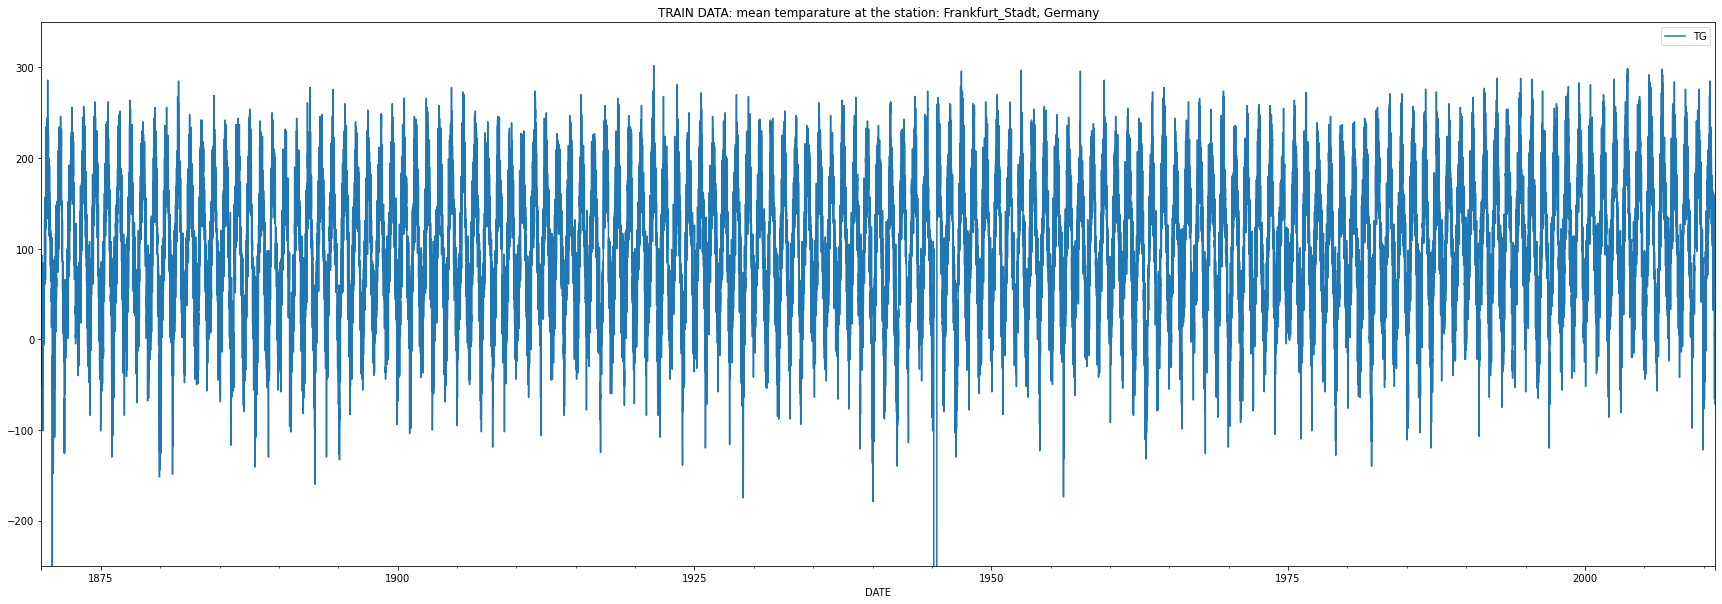

In [20]:
df_train.plot(x='DATE', y='TG', figsize=(30,10))
plt.title(f'TRAIN DATA: mean temparature at the station: {mystation}, Germany')
plt.ylim(-250, 350)
plt.show()

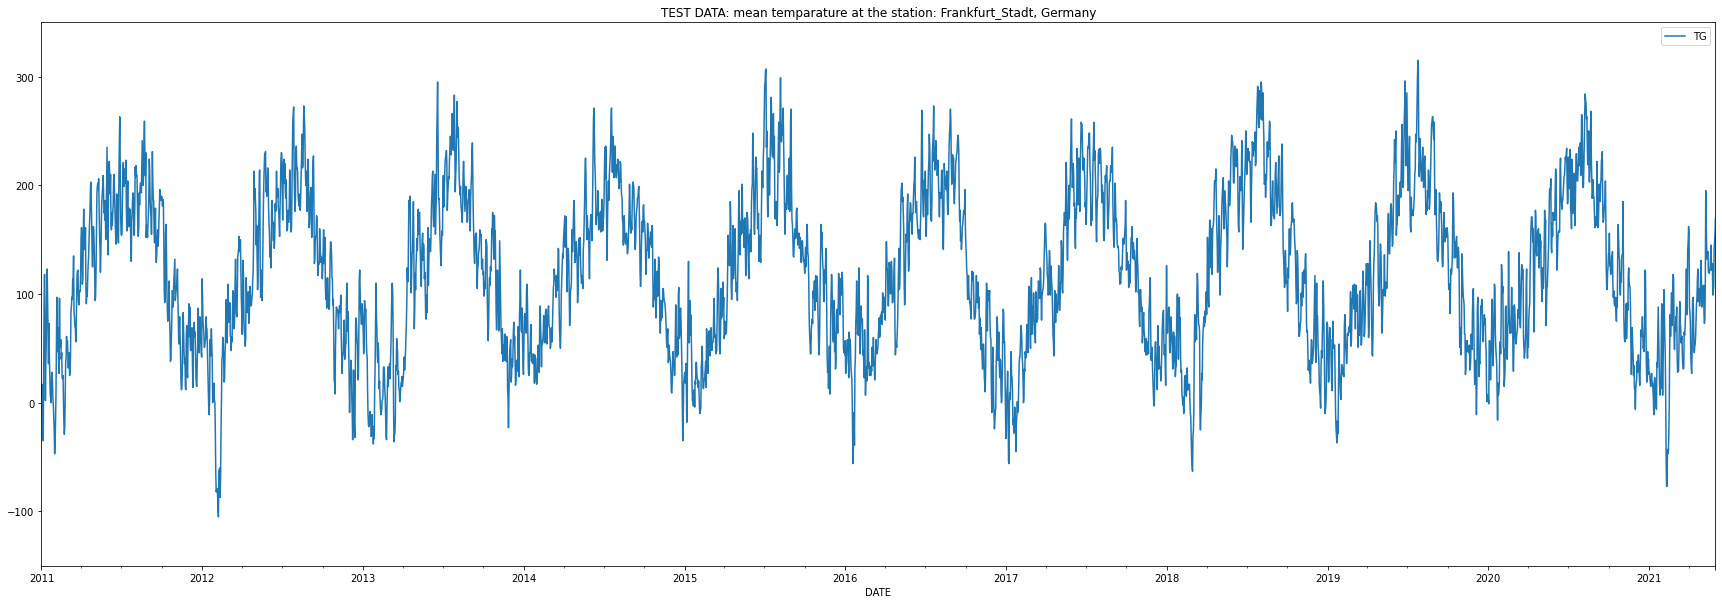

In [21]:
df_test.plot(x='DATE', y='TG', figsize=(30,10))
plt.title(f'TEST DATA: mean temparature at the station: {mystation}, Germany')
plt.ylim(-150, 350)
plt.show()

## 5. Feature Engineering

### 5.1. Create lag columns

In [22]:
df_train.Q_TG.value_counts(), df_test.Q_TG.value_counts()

(0    51406
 9       93
 Name: Q_TG, dtype: int64,
 0    3804
 Name: Q_TG, dtype: int64)

In [23]:
df_train.replace(-9999, np.nan, inplace=True)
df_test.replace(-9999, np.nan, inplace=True)

In [24]:
df_train.TG.isna().sum(), df_test.TG.isna().sum()

(93, 0)

In [25]:
df_train['lag1'] = df_train['TG'].shift(1)
df_train['lag2'] = df_train['TG'].shift(2)
df_train['lag3'] = df_train['TG'].shift(3)
df_train['lag4'] = df_train['TG'].shift(4)

In [26]:
df_test['lag1'] = df_test['TG'].shift(1)
df_test['lag2'] = df_test['TG'].shift(2)
df_test['lag3'] = df_test['TG'].shift(3)
df_test['lag4'] = df_test['TG'].shift(4)

### 5.2. handle existing and propagated NaNs

In [27]:
#mylist = df_train.index[df_train.TG.isna() == True].tolist()
#mylist

In [28]:
df_train.isna().sum()

SOUID     0
DATE      0
TG       93
Q_TG      0
INDEX     0
lag1     94
lag2     95
lag3     96
lag4     97
dtype: int64

In [29]:
df_test.isna().sum()

SOUID    0
DATE     0
TG       0
Q_TG     0
INDEX    0
lag1     1
lag2     2
lag3     3
lag4     4
dtype: int64

In [30]:
df_train.dropna(axis=0, inplace=True)

### 5.3. handle NaNs at the split

In [31]:
df_train.tail()

,SOUID,DATE,TG,Q_TG,INDEX,lag1,lag2,lag3,lag4
51494,122364,2010-12-27,-28.0,0,51494,-72.0,-42.0,-5.0,24.0
51495,122364,2010-12-28,-17.0,0,51495,-28.0,-72.0,-42.0,-5.0
51496,122364,2010-12-29,-16.0,0,51496,-17.0,-28.0,-72.0,-42.0
51497,122364,2010-12-30,-19.0,0,51497,-16.0,-17.0,-28.0,-72.0
51498,122364,2010-12-31,-18.0,0,51498,-19.0,-16.0,-17.0,-28.0


In [32]:
df_test.head()

,SOUID,DATE,TG,Q_TG,INDEX,lag1,lag2,lag3,lag4
51499,122364,2011-01-01,6,0,51499,NaN,NaN,NaN,NaN
51500,122364,2011-01-02,17,0,51500,6.0,NaN,NaN,NaN
51501,122364,2011-01-03,5,0,51501,17.0,6.0,NaN,NaN
51502,122364,2011-01-04,-23,0,51502,5.0,17.0,6.0,NaN
51503,122364,2011-01-05,-35,0,51503,-23.0,5.0,17.0,6.0


In [33]:
i = df_test.index[0]

df_test.loc[i+0, 'lag1'] = df_train.iloc[-1].TG
df_test.loc[i+1, 'lag2'] = df_train.iloc[-1].TG
df_test.loc[i+2, 'lag3'] = df_train.iloc[-1].TG
df_test.loc[i+3, 'lag4'] = df_train.iloc[-1].TG

df_test.loc[i+0, 'lag2'] = df_train.iloc[-2].TG
df_test.loc[i+1, 'lag3'] = df_train.iloc[-2].TG
df_test.loc[i+2, 'lag4'] = df_train.iloc[-2].TG

df_test.loc[i+0, 'lag3'] = df_train.iloc[-3].TG
df_test.loc[i+1, 'lag4'] = df_train.iloc[-3].TG

df_test.loc[i, 'lag4'] = df_train.iloc[-4].TG

In [34]:
df_test

,SOUID,DATE,TG,Q_TG,INDEX,lag1,lag2,lag3,lag4
51499,122364,2011-01-01,6,0,51499,-18.0,-19.0,-16.0,-17.0
51500,122364,2011-01-02,17,0,51500,6.0,-18.0,-19.0,-16.0
51501,122364,2011-01-03,5,0,51501,17.0,6.0,-18.0,-19.0
51502,122364,2011-01-04,-23,0,51502,5.0,17.0,6.0,-18.0
51503,122364,2011-01-05,-35,0,51503,-23.0,5.0,17.0,6.0
...,...,...,...,...,...,...,...,...,...
55298,122364,2021-05-27,107,0,55298,103.0,99.0,128.0,127.0
55299,122364,2021-05-28,140,0,55299,107.0,103.0,99.0,128.0
55300,122364,2021-05-29,149,0,55300,140.0,107.0,103.0,99.0
55301,122364,2021-05-30,156,0,55301,149.0,140.0,107.0,103.0


## 6. Train a model
- Which models could we use?
    - Some that we know:
        - e.g. Linear regression, *Q*: what would that capture? --> the trend
    - Some that we don't know:
        - `Encounter: Linear Autoregression` + `Encounter: Arima` (Tue, Wed)

### 6.1. Linear Regression on Trend

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [36]:
mt = LinearRegression()

In [37]:
X_train = df_train[['INDEX']]
y_train = df_train['TG']

In [38]:
mt.fit(X_train, y_train)

LinearRegression()

In [39]:
df_train['trend'] = mt.predict(X_train)

In [40]:
mean_absolute_error(df_train.TG, df_train.trend)

62.960631818355466

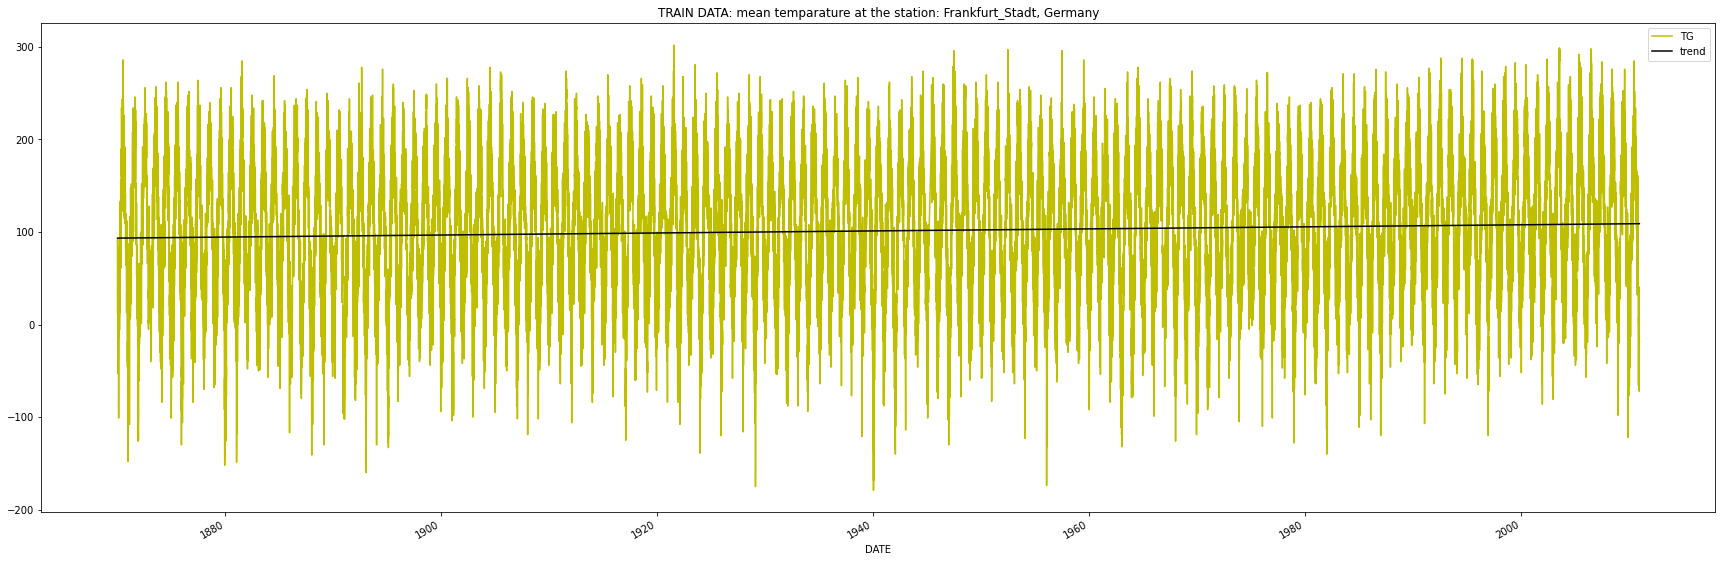

In [41]:
df_train.plot(x='DATE', y=['TG', 'trend'], color=['y', 'k'], figsize=(30,10))
plt.title(f'TRAIN DATA: mean temparature at the station: {mystation}, Germany')
plt.show()

In [42]:
365.25 * mt.coef_[0]

0.11057527653242702

### 6.2. Linear Regression on Trend + Seasonal

In [43]:
df_train['month'] = df_train['DATE'].dt.month

In [44]:
month_dummies = pd.get_dummies(df_train.month, prefix = 'm')

In [45]:
df_train = df_train.join(month_dummies)

In [46]:
df_train.head()

,SOUID,DATE,TG,Q_TG,INDEX,lag1,lag2,lag3,lag4,trend,...,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
4,122376,1870-01-05,12.0,0,4,26.0,25.0,26.0,-24.0,93.440404,...,0,0,0,0,0,0,0,0,0,0
5,122376,1870-01-06,36.0,0,5,12.0,26.0,25.0,26.0,93.440707,...,0,0,0,0,0,0,0,0,0,0
6,122376,1870-01-07,61.0,0,6,36.0,12.0,26.0,25.0,93.441009,...,0,0,0,0,0,0,0,0,0,0
7,122376,1870-01-08,93.0,0,7,61.0,36.0,12.0,26.0,93.441312,...,0,0,0,0,0,0,0,0,0,0
8,122376,1870-01-09,73.0,0,8,93.0,61.0,36.0,12.0,93.441615,...,0,0,0,0,0,0,0,0,0,0


In [47]:
X_train = df_train[['INDEX', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']]
y_train = df_train['TG']

In [48]:
mts = LinearRegression()

In [49]:
mts.fit(X_train,y_train)

LinearRegression()

In [50]:
#df.drop(axis=1, labels='trend_month', inplace=True)

In [51]:
df_train['trend_month'] = mts.predict(X_train)

In [52]:
mean_absolute_error(df_train.TG, df_train.trend_month)

29.84712327020099

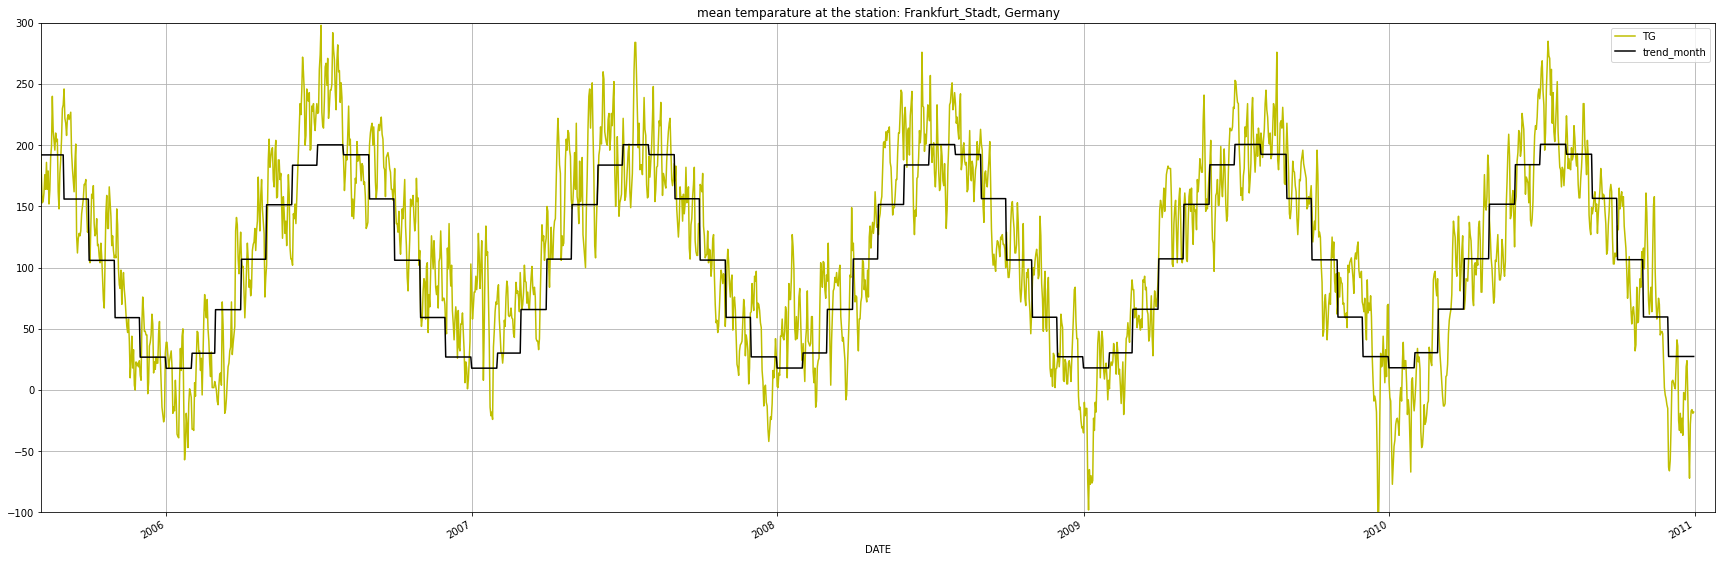

In [53]:
df_train.plot(x='DATE', y=['TG', 'trend_month'], color=['y', 'k'], figsize=(30,10), grid=True)
plt.title(f'mean temparature at the station: {mystation}, Germany')
plt.xlim(13000, 15000)
plt.ylim(-100, 300)
plt.show()

In [54]:
365.25 * mts.coef_[0]

0.10920408285820066

coefficient (lin reg slope) with full data was: 0.1347389166057842

In [55]:
mts.coef_[1:]

array([-90.22679935, -77.91489827, -42.34067092,  -1.16394509,
        43.35906338,  75.64528199,  92.28944195,  84.1708163 ,
        48.09955284,  -2.0036789 , -48.81324786, -81.10091608])

### 6.3. Partial Autocorrelation

In [56]:
df_train['remainder'] = df_train['TG'] - df_train['trend_month']

In [57]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

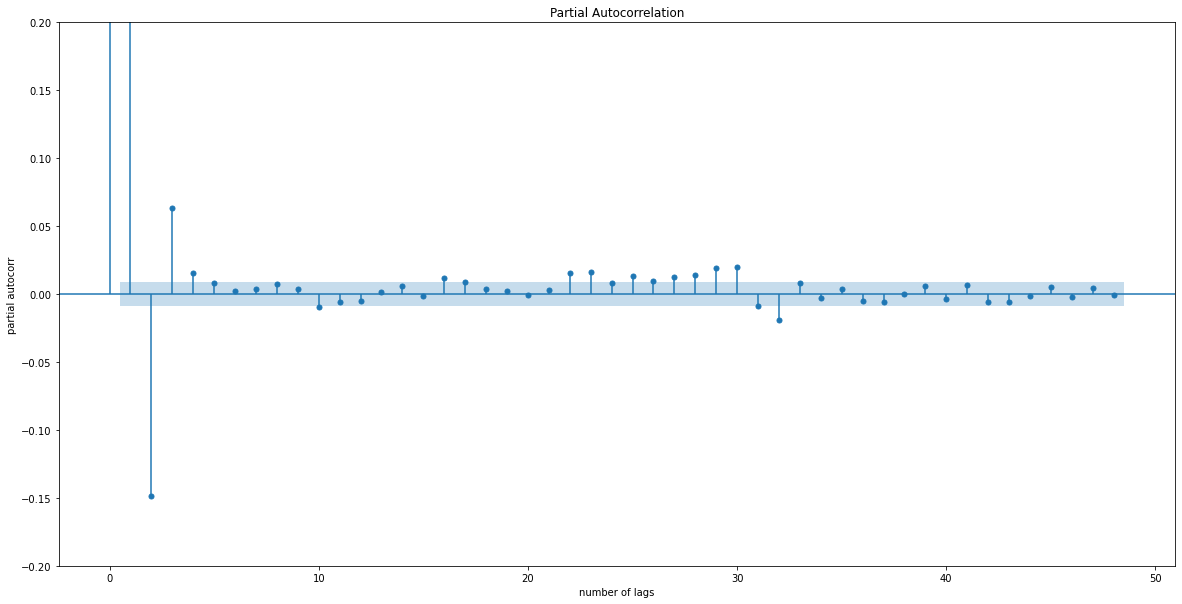

In [58]:
fig = plot_pacf(df_train['remainder'])
fig.set_size_inches(20, 10)
plt.ylim(-0.2, 0.2)
plt.xlabel('number of lags')
plt.ylabel('partial autocorr')
plt.show()

### 6.4. Autocorrelation

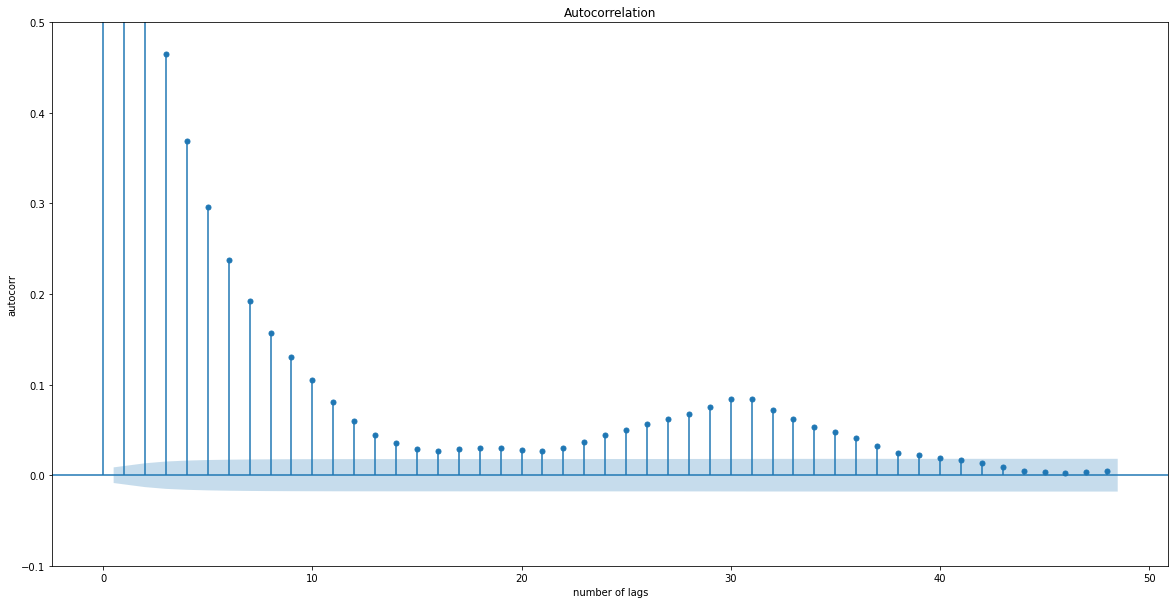

In [59]:
fig = plot_acf(df_train['remainder'])
fig.set_size_inches(20, 10)
plt.ylim(-0.1, 0.5)
plt.xlabel('number of lags')
plt.ylabel('autocorr')
plt.show()

### 6.5. select order and AutoArima

In [60]:
from statsmodels.tsa.ar_model import ar_select_order

In [61]:
selected_order = ar_select_order(df_train.remainder, maxlag=12)
selected_order.ar_lags # tells us to use this lag

/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


array([1, 2, 3, 4])

In [62]:
selected_order.aic

{(1, 2, 3, 4, 5): 6.1491388178432995,
 (1, 2, 3, 4): 6.149163241974112,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 6.149165876640085,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): 6.149166996396803,
 (1, 2, 3, 4, 5, 6): 6.149173868124842,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 6.149175575991807,
 (1, 2, 3, 4, 5, 6, 7, 8): 6.14918650204598,
 (1, 2, 3, 4, 5, 6, 7): 6.149197346932279,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): 6.14921256566315,
 (1, 2, 3): 6.149358336378805,
 (1, 2): 6.153368955286317,
 (1,): 6.175582383244508,
 0: 7.245902549334943}

In [63]:
#from pmdarima.arima import auto_arima

In [64]:
#auto_arima_model = auto_arima(y=df.remainder, start_p=0, start_q=0, max_p=10, max_q=10, d=None)

In [65]:
#auto_arima_model

**auto_arima** for remainder with 55k values, p=0-10, q=0-10 took **35 mins** to calculate

ARIMA(order=(0, 1, 6), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### 6.6. Liner Regression with: trend, month and 4 autoregressive features

In [66]:
df_train.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG', 'INDEX', 'lag1', 'lag2', 'lag3', 'lag4',
       'trend', 'month', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7',
       'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'trend_month', 'remainder'],
      dtype='object')

In [67]:
Xar_train = df_train[['INDEX', 'lag1', 'lag2', 'lag3', 'lag4', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']]
yar_train = df_train['TG']

In [68]:
mar = LinearRegression()

In [69]:
mar.fit(Xar_train, yar_train)

LinearRegression()

In [70]:
df_train['arpredict'] = mar.predict(Xar_train)

In [71]:
mar.score(Xar_train, yar_train)

0.9220320128169969

In [72]:
mean_absolute_error(df_train.TG, df_train.arpredict)

16.31051828424961

- no autoregr.: 29.84
- only `lag1`: 16.58
- with `lag4`: 16.31

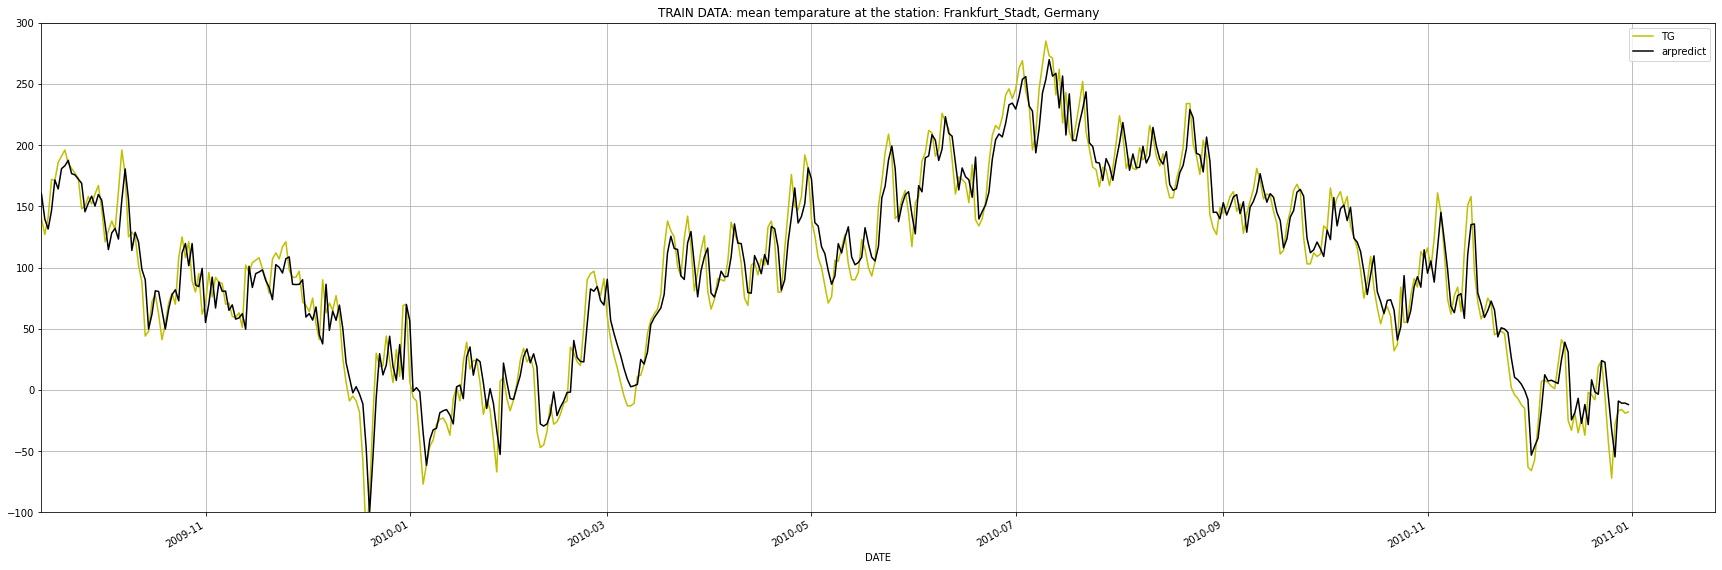

In [73]:
df_train.plot(x='DATE', y=['TG', 'arpredict'], color=['y', 'k'], figsize=(30,10), grid=True)
plt.title(f'TRAIN DATA: mean temparature at the station: {mystation}, Germany')
plt.xlim(14500, 15000)
plt.ylim(-100, 300)
plt.show()

In [74]:
#from statsmodels.tsa.ar_model import AutoReg

In [75]:
#statsmodels_ar = AutoReg(df['TG'], lags=4, trend='ct', seasonal=True, period=365).fit()

In [76]:
#df['ar2_predict'] = statsmodels_ar.predict()

In [77]:
#df.head()

In [78]:
#df.dropna(inplace=True)

In [79]:
#mean_absolute_error(df.TG, statsmodels_ar.predict())

### 6.7. ARIMA

In [81]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

In [82]:
# cut a lot of old data off
si = df.loc[df.DATE == '1971-01-01'].index[0] - 105
df_train2 = df_train[si:].copy()
df_train2.shape[0] / 365.25

40.0

In [145]:
df_train2.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG', 'INDEX', 'lag1', 'lag2', 'lag3', 'lag4',
       'trend', 'month', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7',
       'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'trend_month', 'remainder',
       'arpredict'],
      dtype='object')

In [147]:
X_train2 = df_train2[['INDEX', 'lag1', 'lag2', 'lag3', 'lag4', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']]
y_train2 = df_train2['remainder']

In [149]:
arima_fourzerozero = ARIMA(endog=y_train2, order=(4,0,0)).fit()

/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [150]:
arima_fourzerozero.predict()

36889     0.242776
36890   -85.549128
36891   -62.790907
36892   -53.443347
36893   -42.827132
           ...    
51494   -80.242404
51495   -36.432679
51496   -36.472483
51497   -36.049290
51498   -37.717631
Name: predicted_mean, Length: 14610, dtype: float64

In [151]:
df_train2['ARIMA-predict'] = arima_fourzerozero.predict()

In [152]:
df_train2

,SOUID,DATE,TG,Q_TG,INDEX,lag1,lag2,lag3,lag4,trend,...,m_7,m_8,m_9,m_10,m_11,m_12,trend_month,remainder,arpredict,ARIMA-predict
36889,122352,1971-01-01,-92.0,0,36889,-70.0,-30.0,-24.0,-28.0,104.606917,...,0,0,0,0,0,0,13.941858,-105.941858,-59.770804,0.242776
36890,122352,1971-01-02,-70.0,0,36890,-92.0,-70.0,-30.0,-24.0,104.607220,...,0,0,0,0,0,0,13.942157,-83.942157,-72.261422,-85.549128
36891,122352,1971-01-03,-54.0,0,36891,-70.0,-92.0,-70.0,-30.0,104.607523,...,0,0,0,0,0,0,13.942456,-67.942456,-48.812423,-62.790907
36892,122352,1971-01-04,-40.0,0,36892,-54.0,-70.0,-92.0,-70.0,104.607826,...,0,0,0,0,0,0,13.942755,-53.942755,-40.669644,-53.443347
36893,122352,1971-01-05,-64.0,0,36893,-40.0,-54.0,-70.0,-92.0,104.608128,...,0,0,0,0,0,0,13.943054,-77.943054,-30.250305,-42.827132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51494,122364,2010-12-27,-28.0,0,51494,-72.0,-42.0,-5.0,24.0,109.028415,...,0,0,0,0,0,1,27.434409,-55.434409,-54.729852,-80.242404
51495,122364,2010-12-28,-17.0,0,51495,-28.0,-72.0,-42.0,-5.0,109.028717,...,0,0,0,0,0,1,27.434708,-44.434708,-9.059938,-36.432679
51496,122364,2010-12-29,-16.0,0,51496,-17.0,-28.0,-72.0,-42.0,109.029020,...,0,0,0,0,0,1,27.435007,-43.435007,-10.813240,-36.472483
51497,122364,2010-12-30,-19.0,0,51497,-16.0,-17.0,-28.0,-72.0,109.029323,...,0,0,0,0,0,1,27.435306,-46.435306,-10.756118,-36.049290


In [153]:
mean_absolute_error(df_train2.remainder, df_train2['ARIMA-predict'])

17.107947245176778

In [144]:
mean_absolute_error(y_train2, arima_fourzerozero.predict())

16.60934439135831

**Mean absolute errors of (full) train data:**
- ARIMA (0,1,6) = 16.67 no exog
- ARIMA (0,1,6) = 16.51 exog=Xar_train
- ARIMA (4,1,4) = 16.67
- ARIMA (4,0,0) = 16.85 no exog
- ARIMA (4,0,0) = 16.80 with exog
- ARIMA (4,0,0) = 16.31 exog=Xar_train

## 7. Cross-Validate and Optimize Hyperparameters

### 7.1. Cross-Val-Score for LinReg with autoreg

In [86]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score

In [87]:
ts_split = TimeSeriesSplit(n_splits=9)

In [88]:
ts_split.split(Xar_train, yar_train)

<generator object TimeSeriesSplit.split at 0x7f14e6cfa660>

In [89]:
for i, (ti, vi) in enumerate(ts_split.split(Xar_train, yar_train)):
    print(f'- iteration {i+1}: train on {ti[0]} - {ti[-1]} and test on {vi[0]} - {vi[-1]}')

- iteration 1: train on 0 - 5142 and test on 5143 - 10281
- iteration 2: train on 0 - 10281 and test on 10282 - 15420
- iteration 3: train on 0 - 15420 and test on 15421 - 20559
- iteration 4: train on 0 - 20559 and test on 20560 - 25698
- iteration 5: train on 0 - 25698 and test on 25699 - 30837
- iteration 6: train on 0 - 30837 and test on 30838 - 35976
- iteration 7: train on 0 - 35976 and test on 35977 - 41115
- iteration 8: train on 0 - 41115 and test on 41116 - 46254
- iteration 9: train on 0 - 46254 and test on 46255 - 51393


In [90]:
result = cross_val_score(estimator=mar, X=Xar_train, y=yar_train, cv=ts_split.split(Xar_train, yar_train))

In [91]:
result

array([0.93346192, 0.91755118, 0.90686426, 0.92240827, 0.92851273,
       0.91657399, 0.91485746, 0.91521607, 0.92346947])

In [92]:
result.mean()

0.9198794825384291

### 7.2. Cross-Val-Score for ARIMA

In [93]:
# Build a cross validator for the statsmodels models
def cross_validator(X, y, order):
    '''
    Build an easy to understand cross-validator for statsmodels time series models.
    by Stephan Roth @ Spiced Academy
    
    Args:
        model: The ARIMA model to use for the evaluation.
        X: The input features for the model
        y: The variable of interest
    
    Returns:
        list: The R^2 values for all the CV splits.
    '''
    ts_split = TimeSeriesSplit(n_splits=7)
    result_list = []
    
    for ti, vi in ts_split.split(X, y):
        
        print(f'train {len(ti)}, test {len(vi)}')
        m = ARIMA(endog=y.iloc[ti], exog=X.iloc[ti], order=order).fit()
        s = r2_score( y_true=y.iloc[vi] , y_pred=m.forecast( steps=len(vi), exog=X.iloc[vi] ) )
        result_list.append(s)
    
    return np.array(result_list)

In [341]:
#arima_scores = cross_validator(X_train2, y_train2, (0,1,6))

train 1828, test 1826


/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/nico/anaconda3/lib/python3.8/site-

train 3654, test 1826


/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3

train 5480, test 1826


/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3

train 7306, test 1826


/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3

train 9132, test 1826


/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3

train 10958, test 1826


/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nico/anaconda3

train 12784, test 1826


/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [342]:
#arima_scores

array([-0.34315451,  0.17305595,  0.80186692,  0.78482966,  0.87581909,
        0.59686042,  0.71993796])

## 8. Test

### 8.1. Test-Score for LinReg with autoreg

In [94]:
df_test.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG', 'INDEX', 'lag1', 'lag2', 'lag3', 'lag4'], dtype='object')

In [95]:
df_test.shape

(3804, 9)

In [96]:
df_test['month'] = df_test['DATE'].dt.month

In [97]:
month_dummies = pd.get_dummies(df_test.month, prefix = 'm')

In [98]:
X_test = df_test[['INDEX', 'lag1', 'lag2', 'lag3', 'lag4']].join(month_dummies)
y_test = df_test['TG']
X_test.shape, y_test.shape

((3804, 17), (3804,))

In [99]:
X_test

,INDEX,lag1,lag2,lag3,lag4,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
51499,51499,-18.0,-19.0,-16.0,-17.0,1,0,0,0,0,0,0,0,0,0,0,0
51500,51500,6.0,-18.0,-19.0,-16.0,1,0,0,0,0,0,0,0,0,0,0,0
51501,51501,17.0,6.0,-18.0,-19.0,1,0,0,0,0,0,0,0,0,0,0,0
51502,51502,5.0,17.0,6.0,-18.0,1,0,0,0,0,0,0,0,0,0,0,0
51503,51503,-23.0,5.0,17.0,6.0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55298,55298,103.0,99.0,128.0,127.0,0,0,0,0,1,0,0,0,0,0,0,0
55299,55299,107.0,103.0,99.0,128.0,0,0,0,0,1,0,0,0,0,0,0,0
55300,55300,140.0,107.0,103.0,99.0,0,0,0,0,1,0,0,0,0,0,0,0
55301,55301,149.0,140.0,107.0,103.0,0,0,0,0,1,0,0,0,0,0,0,0


In [112]:
mar.score(X_test, y_test)

0.9247000871799311

In [114]:
df_test['LinAutoReg'] = mar.predict(X_test)
df_test

,SOUID,DATE,TG,Q_TG,INDEX,lag1,lag2,lag3,lag4,month,LinAutoReg
51499,122364,2011-01-01,6,0,51499,-18.0,-19.0,-16.0,-17.0,1,-11.030450
51500,122364,2011-01-02,17,0,51500,6.0,-18.0,-19.0,-16.0,1,11.510783
51501,122364,2011-01-03,5,0,51501,17.0,6.0,-18.0,-19.0,1,16.750148
51502,122364,2011-01-04,-23,0,51502,5.0,17.0,6.0,-18.0,1,4.228871
51503,122364,2011-01-05,-35,0,51503,-23.0,5.0,17.0,6.0,1,-18.585285
...,...,...,...,...,...,...,...,...,...,...,...
55298,122364,2021-05-27,107,0,55298,103.0,99.0,128.0,127.0,5,116.129880
55299,122364,2021-05-28,140,0,55299,107.0,103.0,99.0,128.0,5,117.548286
55300,122364,2021-05-29,149,0,55300,140.0,107.0,103.0,99.0,5,147.531808
55301,122364,2021-05-30,156,0,55301,149.0,140.0,107.0,103.0,5,149.269042


In [115]:
r2_score(df_test.TG, df_test.LinAutoReg)

0.9247000871799311

### 8.2. Test-Score for ARIMA

In [159]:
y_pred = m_arima.forecast( steps=len(X_test), exog=X_test )
r2_score(y_test, y_pred)

/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


0.4297739133044052

In [163]:
pred400 = arima_fourzerozero.forecast( steps=len(X_test) )
pred400

/home/nico/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


14610   -36.005752
14611   -27.632425
14612   -21.670491
14613   -17.270186
14614   -13.765182
           ...    
18409     0.242776
18410     0.242776
18411     0.242776
18412     0.242776
18413     0.242776
Name: predicted_mean, Length: 3804, dtype: float64

<AxesSubplot:>

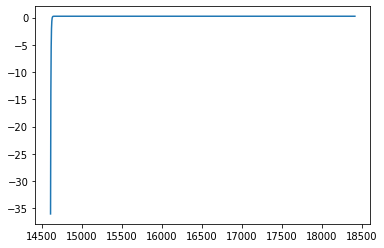

In [164]:
pred400.plot()

In [125]:
y_pred

14610    -19.510671
14611     -6.639944
14612     -4.642980
14613    -17.128414
14614    -26.115747
            ...    
18409    151.970827
18410    160.101038
18411    168.239182
18412    168.482435
18413    164.687351
Name: predicted_mean, Length: 3804, dtype: float64

In [129]:
df_test.reset_index()

,index,SOUID,DATE,TG,Q_TG,INDEX,lag1,lag2,lag3,lag4,month,LinAutoReg,ARIMA-016
0,51499,122364,2011-01-01,6,0,51499,-18.0,-19.0,-16.0,-17.0,1,-11.030450,NaN
1,51500,122364,2011-01-02,17,0,51500,6.0,-18.0,-19.0,-16.0,1,11.510783,NaN
2,51501,122364,2011-01-03,5,0,51501,17.0,6.0,-18.0,-19.0,1,16.750148,NaN
3,51502,122364,2011-01-04,-23,0,51502,5.0,17.0,6.0,-18.0,1,4.228871,NaN
4,51503,122364,2011-01-05,-35,0,51503,-23.0,5.0,17.0,6.0,1,-18.585285,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3799,55298,122364,2021-05-27,107,0,55298,103.0,99.0,128.0,127.0,5,116.129880,NaN
3800,55299,122364,2021-05-28,140,0,55299,107.0,103.0,99.0,128.0,5,117.548286,NaN
3801,55300,122364,2021-05-29,149,0,55300,140.0,107.0,103.0,99.0,5,147.531808,NaN
3802,55301,122364,2021-05-30,156,0,55301,149.0,140.0,107.0,103.0,5,149.269042,NaN


In [133]:
df_test['ARIMA-016'] = y_pred.values

In [139]:
df_test.set_index(keys='DATE', inplace=True)

In [140]:
df_test

,SOUID,TG,Q_TG,INDEX,lag1,lag2,lag3,lag4,month,LinAutoReg,ARIMA-016
DATE,,,,,,,,,,,
2011-01-01,122364,6,0,51499,-18.0,-19.0,-16.0,-17.0,1,-11.030450,-19.510671
2011-01-02,122364,17,0,51500,6.0,-18.0,-19.0,-16.0,1,11.510783,-6.639944
2011-01-03,122364,5,0,51501,17.0,6.0,-18.0,-19.0,1,16.750148,-4.642980
2011-01-04,122364,-23,0,51502,5.0,17.0,6.0,-18.0,1,4.228871,-17.128414
2011-01-05,122364,-35,0,51503,-23.0,5.0,17.0,6.0,1,-18.585285,-26.115747
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,122364,107,0,55298,103.0,99.0,128.0,127.0,5,116.129880,151.970827
2021-05-28,122364,140,0,55299,107.0,103.0,99.0,128.0,5,117.548286,160.101038
2021-05-29,122364,149,0,55300,140.0,107.0,103.0,99.0,5,147.531808,168.239182


In [135]:
import seaborn as sns

(18500, 19000)

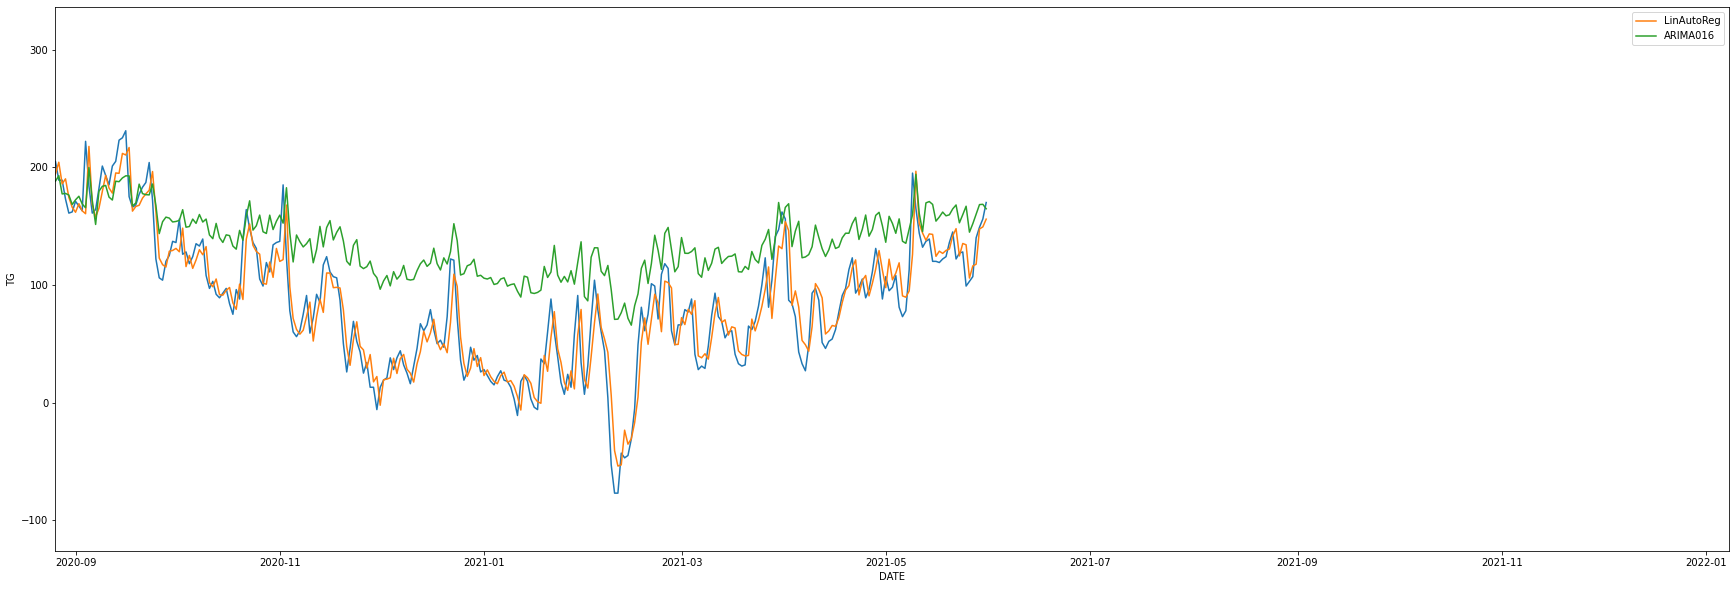

In [173]:
plt.figure(figsize=(30,10))
sns.lineplot(data=df_test.TG)
sns.lineplot(data=df_test.LinAutoReg, label='LinAutoReg')
sns.lineplot(data=df_test['ARIMA-016'], label='ARIMA016')
plt.legend()
plt.xlim(18500,19000)
